In [1]:
import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'

import io
import PIL.Image, PIL.ImageDraw

import requests

import einops
import numpy as np
import matplotlib.pyplot as plt
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

# Notebook dependencies
from IPython.display import clear_output, Image

from torch.profiler import profile, record_function, ProfilerActivity

device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print('device is {}'.format(device))

device is cuda:2


In [2]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print('device is {}'.format(device))
torch.cuda.device_count()
tester = torch.tensor([1,2,3]).to(device)

device is cuda:2


In [3]:
# Utility functions

TARGET_SIZE = 40

"Image processing functions "

def load_image(url, max_size=TARGET_SIZE):
  r = requests.get(url)
  img = PIL.Image.open(io.BytesIO(r.content))
  img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  img = np.float32(img) / 255.0

  # premultiply RGB by Alpha
  img[..., :3] *= img[..., 3:]
  return img

def load_emoji(emoji):
  code = hex(ord(emoji))[2:].lower()
  url = 'https://github.com/googlefonts/noto-emoji/blob/main/png/128/emoji_u%s.png?raw=true'%code
  return load_image(url)

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def to_rgba(x):
  "This function used outside model, using original shaping conventions"
  return x[..., :4]

def get_living_mask(x):
  "This function used within model with PyTorch shaping conventions"
  alpha = x[:, 3:4, :, :]
  return F.max_pool2d(alpha, kernel_size=3, stride=1, padding=1) > 0.1

def to_alpha(x):
  "Assume original TF shaping convention"
  return torch.clamp(x[..., 3:4], 0.0, 1.0)

def to_rgb(x):
  # assume rgb premultiplied by alpha
  rgb, a = x[..., :3], to_alpha(x)
  return 1.0-a+rgb

def visualize_batch(x0, x, step_i):
  vis0 = np.hstack(to_rgb(x0).numpy())
  vis1 = np.hstack(to_rgb(x).numpy())
  vis = np.vstack([vis0, vis1])
  # imwrite('train_log/batches_%04d.jpg'%step_i, vis)
  print('batch (before/after):')
  imshow(vis)

def plot_loss(loss_log):
  plt.figure(figsize=(10, 4))
  plt.title('Loss history (log10)')
  plt.plot(np.log10(loss_log), '.', alpha=0.1)
  plt.show()


In [4]:
# Parameters

CHANNEL_N = 4
TARGET_PADDING = 16
BATCH_SIZE = 8
CELL_FIRE_RATE = 0.5

TARGET_EMOJI = "🛩"

# Load target image
target_img = load_emoji(TARGET_EMOJI)

/tmp/ipykernel_1815438/1231931882.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)


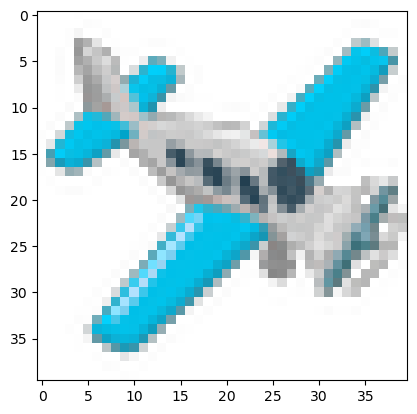

In [5]:
plt.imshow(target_img)
plt.show()

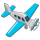

In [6]:
imshow(target_img)

In [38]:
# Define Model

class CAModel(nn.Module):
  def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE):
    super().__init__()
    self.channel_n = channel_n
    self.fire_rate = fire_rate

    conv1 = nn.Conv2d(in_channels=self.channel_n*3, out_channels=128, kernel_size=1)
    conv2 = nn.Conv2d(in_channels=128, out_channels=self.channel_n, kernel_size=1)
    
    # Apply "do-nothing" initial behavior
    torch.nn.init.zeros_(conv2.weight)
    torch.nn.init.zeros_(conv1.bias)
    torch.nn.init.zeros_(conv2.bias)

    self.dmodel = nn.Sequential(
        conv1,
        nn.ReLU(),
        conv2,
    )
    
    # self.dmodel = nn.Sequential(
    #     nn.Conv2d(in_channels=self.channel_n*3, out_channels=128, kernel_size=1),
    #     nn.ReLU(),
    #     nn.Conv2d(in_channels=128, out_channels=self.channel_n, kernel_size=1)
    # )

  def perceive(self, x, angle=0.0):
    """Pytorch does convolutions differently. Reshape accordingly
      input is (batch, in_channels, H, W)
      kernel is (filter_height, filter_width, in_channels, channel_multiplier) in TF
      but should be (out_channels, in_channels / groups, H, W) in Torch"""
    identify = torch.as_tensor([0, 1, 0], dtype=torch.float32)
    identify = torch.outer(identify, identify)
    dx = torch.as_tensor(np.outer([1, 2, 1], [-1, 0, 1]) / 8.0, dtype=torch.float32) # Sobel filter
    dy = dx.T
    c, s = torch.cos(torch.tensor(angle)), torch.sin(torch.tensor(angle))
    stacked_filters = torch.stack((identify, c*dx-s*dy, s*dx+c*dy)).to(device)
    kernel = torch.repeat_interleave(stacked_filters, self.channel_n, dim=0).view(self.channel_n*3, 1, 3, 3)
    y = F.conv2d(x, kernel, padding='same', groups=self.channel_n)
    return y

  def forward(self, x, fire_rate=None, angle=0.0, step_size=1.0):
    x = torch.permute(x, (0, 3, 1, 2)) # make it shape [batch_size, in_channels, H, W]
    # x = x.view(0, 3, 1, 2)
    pre_life_mask = get_living_mask(x)

    y = self.perceive(x, angle) # y should be on device
    dx = self.dmodel(y)*step_size
    if fire_rate is None:
      fire_rate = self.fire_rate
    # update_mask = torch.rand(x.shape, dtype=torch.float32)[:, :1, :, :] <= fire_rate
    # x = x + dx * update_mask.to(device)
    x = x + dx

    post_life_mask = get_living_mask(x)
    life_mask = pre_life_mask & post_life_mask
    result = x * life_mask
    return torch.permute(result, (0, 2, 3, 1)) # send it back [batch_size, H, W, in_channels]

CAModel().dmodel

Sequential(
  (0): Conv2d(12, 128, kernel_size=(1, 1), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(128, 4, kernel_size=(1, 1), stride=(1, 1))
)

seed shape is torch.Size([72, 72, 4])


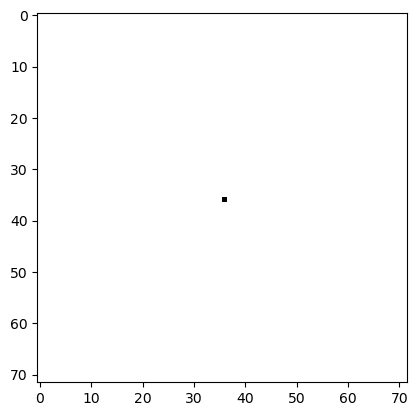

In [39]:
# Make training sample

p = TARGET_PADDING
target_img_tensor = torch.tensor(target_img)
pad_target = torch.nn.functional.pad(target_img_tensor, (0, 0, p, p, p, p))
h, w = pad_target.shape[:2]
seed = torch.zeros(h, w, CHANNEL_N, dtype=torch.float32)
seed[h//2, w//2, 3:] = 1.0
print(f'seed shape is {seed.shape}')

plt.imshow(seed[..., :4])
plt.show()

In [49]:
# Training Sequence

class Train:
  def __init__(self, ca_model, target, lr=2e-3):
    self.ca = ca_model
    self.target = einops.repeat(target, '... -> b ...', b=BATCH_SIZE)
    self.lr = lr
    # Initialize optimizer = no learning rate scheduler for now
    self.optim = torch.optim.Adam(self.ca.parameters(), lr=self.lr)
    # Use library MSELoss
    self.loss_f = nn.MSELoss()

    # Log the training progress
    self.loss_log = []

  def train(self, x0, n_steps=1000):
    "Just support Growing mode for now"

    for i in range(n_steps+1):

      # Run through a single training step of the model
      x, loss = self._train_step(x0)
      self.loss_log.append(loss)
      # print(f'loss log is {self.loss_log}')

      # Printing
      if i % 100 == 0:
        clear_output()

        # visualize batch
        visualize_batch(x0.detach().cpu(), x.detach().cpu(), i)
        
        # plot loss
        plot_loss(self.loss_log)
        # export model

      print('\r step: %d, log10(loss): %.3f'%(i, np.log10(loss)), end='')

    return self.loss_log
    
  def _train_step(self, x):
    """Perform the update step some random number of times"""
    iter_n = np.random.randint(64, 97, dtype=np.int32)
    # Clear previous gradients accumulated on parameters
    self.optim.zero_grad()
    # x = x.to(device)
    for _ in range(iter_n):
      # Forward pass of model
      x = self.ca(x)

    # Compute loss
    loss = self.loss_f(to_rgba(x), self.target)
    # loss = self._loss_f(x, self.target).mean()

    # Compute gradients
    loss.backward()
    
    # Update parameters
    self.optim.step()

    # detached_loss = loss.detach().cpu().numpy()
    # torch.cuda.empty_cache()

    return x, loss.item()

  def _loss_f(self, output, target):
    return torch.square(to_rgba(output) - target).mean(dim=(-2, -3, -1))


In [50]:
x0 = torch.repeat_interleave(seed[None, ...], BATCH_SIZE, dim=0)
subbed = to_rgba(x0) - pad_target
print(subbed.shape)
squared = torch.square(subbed)
print(squared.shape)
meaned = squared.mean((-2, -3, -1)).mean()
print(meaned)
func = F.mse_loss(to_rgba(x0), einops.repeat(pad_target, '... -> b ...', b=BATCH_SIZE))
print(func.shape, func)

torch.Size([8, 72, 72, 4])
torch.Size([8, 72, 72, 4])
tensor(0.0614)
torch.Size([]) tensor(0.0614)


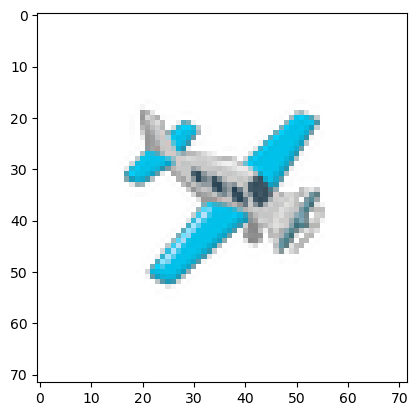

In [51]:
plt.imshow(pad_target.cpu().numpy())
plt.show()

In [52]:
ca = CAModel().to(device)
train = Train(ca, pad_target.to(device))

batch (before/after):


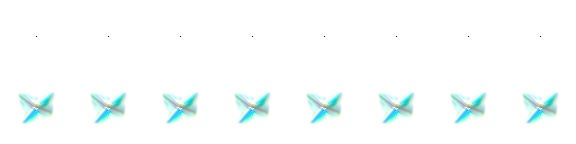

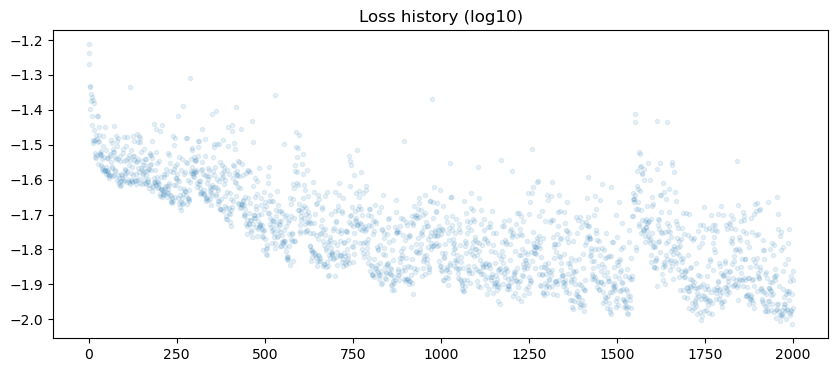

 step: 2001, log10(loss): -1.785

In [53]:
# Seed input each time (starting from a single seed pixel)
x0 = torch.repeat_interleave(seed[None, ...], BATCH_SIZE, dim=0)
loss_log = train.train(x0.to(device), n_steps=2001)

In [45]:
def simulate_model(model, init, n_steps):
    x = init.to(device)
    for _ in range(n_steps):
        x = ca(x)
    plt.imshow(first[0, ...].detach().cpu())
    visualize_batch(init.detach().cpu(), x.detach().cpu(), n_steps)
    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch (before/after):


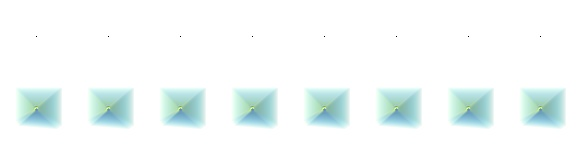

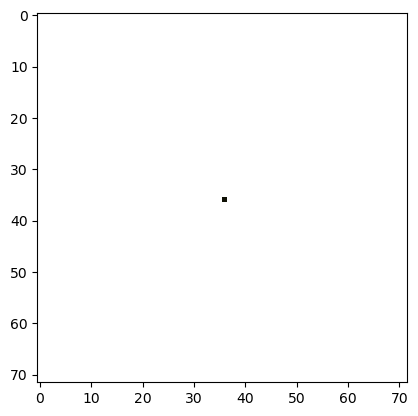

In [46]:
N = 100
result = simulate_model(ca, x0, N)

In [29]:
(result == 0).all()

tensor(True, device='cuda:2')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch (before/after):


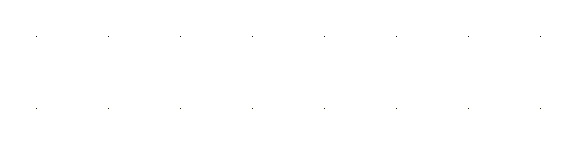

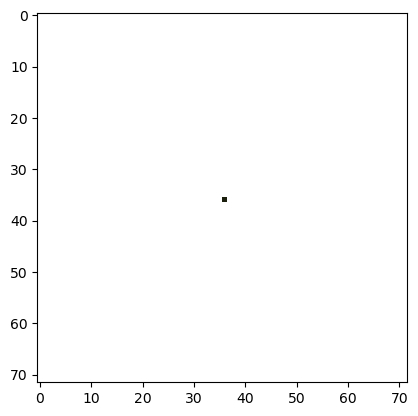

In [22]:
second = ca(first.to(device))
plt.imshow(second[0, ...].detach().cpu())
visualize_batch(first.detach().cpu(), second.detach().cpu(), 1)

In [41]:
weights = []
for i, m in enumerate(ca.modules()):
    print(f'at step {i}')
    print(m)
    print()
    if isinstance(m, nn.Conv2d):
        weight = m.state_dict()['weight']
        weights.append(weight)
        # print(weight)

at step 0
CAModel(
  (dmodel): Sequential(
    (0): Conv2d(12, 128, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 4, kernel_size=(1, 1), stride=(1, 1))
  )
)

at step 1
Sequential(
  (0): Conv2d(12, 128, kernel_size=(1, 1), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(128, 4, kernel_size=(1, 1), stride=(1, 1))
)

at step 2
Conv2d(12, 128, kernel_size=(1, 1), stride=(1, 1))

at step 3
ReLU()

at step 4
Conv2d(128, 4, kernel_size=(1, 1), stride=(1, 1))



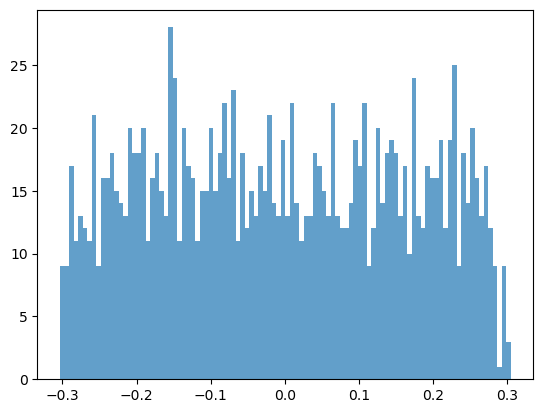

In [60]:
weight1 = weights[0].detach().cpu()
weight2 = weights[1].detach().cpu()
plt.hist(weight1.flatten(), alpha=0.7, bins=100)
plt.show()

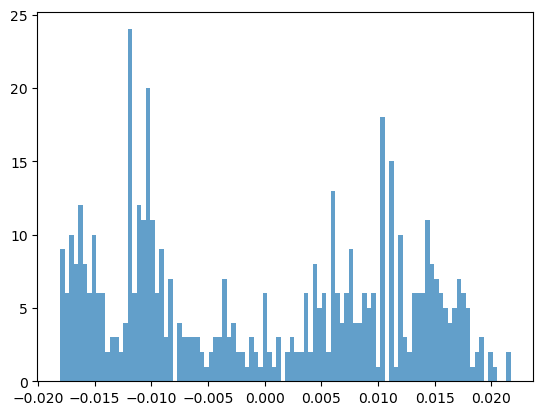

In [61]:
# plt.plot(weight2.flatten())
plt.hist(weight2.flatten(), alpha=0.7, bins=100)
plt.show()

In [63]:
loss_log

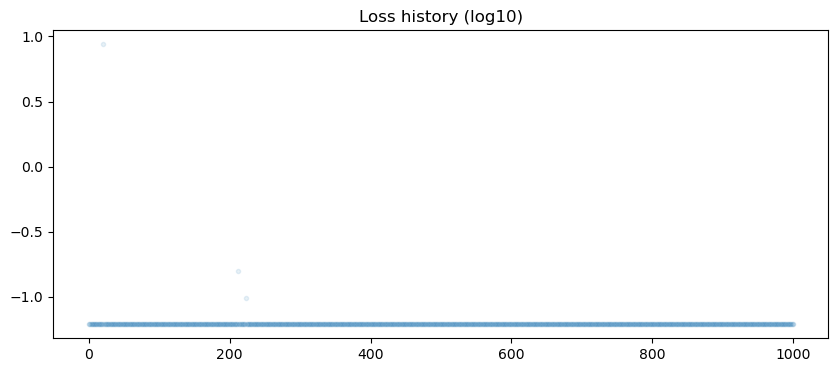

 step: 1001, log10(loss): -1.212

In [20]:
# Seed input each time (starting from a single seed pixel)
x0 = torch.repeat_interleave(seed[None, ...], BATCH_SIZE, dim=0)
loss_log = train.train(x0.to(device))

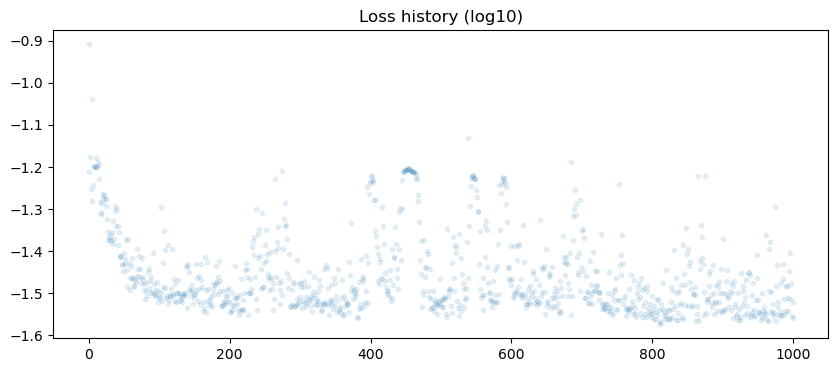

 step: 1001, log10(loss): -1.519

In [19]:
# Seed input each time (starting from a single seed pixel)
x0 = torch.repeat_interleave(seed[None, ...], BATCH_SIZE, dim=0)
loss_log = train.train(x0.to(device))

In [1]:
x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0)
print(seed.shape)
print(x0.shape)

NameError: name 'np' is not defined

In [ ]:
x0_tensor = torch.repeat_interleave(seed[None, ...], BATCH_SIZE, dim=0)
x0_tensor.shape

In [ ]:
ca = CAModel()
output = ca(x0)
output.shape

torch.Size([8, 16, 72, 72])

In [33]:
import tensorflow as tf

In [34]:
def loss_f(x):
  return tf.reduce_mean(tf.square(to_rgba(x)-pad_target), [-2, -3, -1])

In [ ]:
seed

In [38]:
testing = loss_f(seed)
print(type(testing))
print(testing.shape)
print(testing)

<class 'tensorflow.python.framework.ops.EagerTensor'>
()
tf.Tensor(0.061350375, shape=(), dtype=float32)
